# Задание 2: Спрос

In [1]:
from typing import List, Dict, Any, Tuple, Union, Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

## Вспомогательные функции

In [2]:
from typing import List, Tuple

# Добавляем новые фичи (окна, сезонные фичи)


def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(
            lambda x: x.asfreq("1D")
            .rolling(window=window, closed="left", min_periods=0)
            .mean()
            .shift(shift)
        )
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df


def postprocess_transform(
    df: pd.DataFrame,
    norms: List[Tuple[str, str]],
    roll_cols: List[str],
    windows: List[int],
    dropna_cols: List[str],
    lvl: str,
    shift: int,
):
    # new features
    for window in windows:
        for col in roll_cols:
            logger.info(f"Rolling window={window} days for col `{col}`")
            df = calc_rolling_window(
                df=df, window=window, col=col, lvl=lvl, shift=shift
            )

    # normalisation
    # нормализация даст сигнал модели об изменении признаков: если изменилась цена, то к какому изменению спроса это привело?
    for col1, col2 in norms:
        logger.info(f"Normalizing `{col1}` / `{col2}`")
        df[col1] = df[col1] / (
            df[col2] + 1e-10
        )  # добавляем epsilon, чтобы не было деления на 0

    # postprocessing
    # для однородности данных удаляем первые даты, по которым собирались окна не по полным данным
    disadvantaged_ds_list = sorted(df["ds"].unique())[: max(shift, max(windows))]
    df = df[~df["ds"].isin(disadvantaged_ds_list)]

    df = df.dropna(subset=dropna_cols)
    df = df.round(2)
    df = df.sort_values(["ds", lvl])
    return df


def create_features(df: pd.DataFrame, dropna_cols: List[str], W: int) -> pd.DataFrame:
    df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
    df = postprocess_transform(
        df=df,
        norms=[
            ("orders_num", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_1", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_7", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_14", f"rolling_orders_num_w_{W}"),
            ("rolling_orders_num_w_21", f"rolling_orders_num_w_{W}"),
            ("discount", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_1", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_7", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_14", f"rolling_discount_w_{W}"),
            ("rolling_discount_w_21", f"rolling_discount_w_{W}"),
        ],
        roll_cols=["orders_num", "discount"],
        dropna_cols=dropna_cols,
        windows=[1, 7, 14, 21, 28],
        lvl="sku_id",
        shift=14,
    )
    return df

In [3]:
from catboost import CatBoost, Pool
from typing import List, Dict, Any


# Функция для преобразования данных на вход Catboost
def prepare_pool(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: Optional[str] = None,
) -> Pool:
    data = df[flt_features + cat_features]
    pool = Pool(
        data=data,
        label=df[target] if target is not None else None,
        cat_features=cat_features,
    )
    return pool


# Функция для предсказания спроса с обученной моделью
def predict(
    df: pd.DataFrame,
    model: CatBoost,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
) -> List[float]:
    pool = prepare_pool(
        df=df,
        flt_features=flt_features,
        cat_features=cat_features,
    )
    preds = model.predict(data=pool)
    return preds

## Исторические данные

In [4]:
sales_df = pd.read_parquet("../hm/sales.parquet")
sales_df["ds"] = sales_df["ds"].astype(str)
sales_df.head()

,sku_id,orders_num,discount,ds
282,283,169.0,0.00,20230601
392,393,159.0,0.01,20230601
234,235,1061.0,0.03,20230601
214,215,630.0,0.00,20230601
42,43,198.0,0.01,20230601


In [5]:
categories_df = pd.read_parquet("../hm/categories.parquet")
categories_df.head()

,sku_id,group_1,group_2
33881,199,100004,100004
63640,293,100010,100018
20250,41,100010,100018
45018,325,100003,100032
33182,248,100001,100001


In [6]:
promo_df = pd.read_parquet("../hm/promo.parquet")
promo_df["ds"] = promo_df["ds"].astype(str)
promo_df.head()

,promo,ds
0,jun,20230612
1,no,20240108
2,jun,20230610
3,jun,20230611
4,jun,20230614


In [7]:
# Джойним все данные в единый датасет
orig_df = sales_df.copy(deep=True)
orig_df = orig_df.merge(categories_df, on=["sku_id"])
orig_df = orig_df.merge(promo_df, on=["ds"])
orig_df.head()

,sku_id,orders_num,discount,ds,group_1,group_2,promo
0,283,169.0,0.00,20230601,100000,100006,no
1,393,159.0,0.01,20230601,100009,100021,no
2,235,1061.0,0.03,20230601,100003,100032,no
3,215,630.0,0.00,20230601,100011,100020,no
4,43,198.0,0.01,20230601,100006,100023,no


## Сборка датасета и предсказание

In [8]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "discount",
    "rolling_orders_num_w_1",
    "rolling_orders_num_w_7",
    "rolling_orders_num_w_14",
    "rolling_orders_num_w_21",
    "rolling_discount_w_1",
    "rolling_discount_w_7",
    "rolling_discount_w_14",
    "rolling_discount_w_21",
]
CAT_FEATURES = [
    "sku_id",
    "group_1",
    "group_2",
    "promo",
    "day_of_week",
]
TARGET = "orders_num"
W = 28

In [9]:
# Загружаем модель из 1 Задания
from catboost import CatBoost


model = CatBoost()
model.load_model("demand")

There are invalid params and some of them will be ignored.
Parameter {"feature_weights":{"discount":2}} is ignored, because it cannot be parsed.


In [10]:
START_DS, END_DS = "20240101", "20240114"

# Находим товары для ценообразования
pred_df = sales_df.copy(deep=True)[["sku_id"]].drop_duplicates()

# Наджойниваем даты для предсказания
ds_list = pd.date_range(START_DS, END_DS)
ds_list = [ds.strftime("%Y%m%d") for ds in ds_list]
ds_df = pd.DataFrame({"ds": ds_list})
ds_df["promo"] = "no"
pred_df = pred_df.join(ds_df, how="cross")

# Конкатим с историческими данными, чтобы посчитать оконные фичи
cols = pred_df.columns.tolist() + ["orders_num", "discount"]
pred_df["orders_num"] = None
pred_df["discount"] = None
pred_df = pd.concat([orig_df.copy(deep=True)[cols], pred_df[cols]])

# Считаем фичи
pred_df = create_features(df=pred_df, dropna_cols=[], W=W)
pred_df = pred_df[pred_df["ds"].between(START_DS, END_DS)]
pred_df = pred_df.drop(columns=["orders_num", "discount"])

# Наджойниваем категории и комиссии
pred_df = pred_df.merge(categories_df, how="inner", on=["sku_id"])

# Рассчитываем новые цены с учетом "+/-10% от текущей цены"
# Если у вас есть ограничения на цены, то как раз здесь их можно применить
discounts_df = pd.DataFrame(
    {"discount": np.arange(-0.05, 0.06, 0.01).round(2).tolist()}
)
pred_df = pred_df.join(discounts_df, how="cross")
pred_df["orig_discount"] = pred_df["discount"]
pred_df["discount"] = (pred_df["discount"] / pred_df[f"rolling_discount_w_{W}"]).round(
    2
)


# предсказываем спрос с помощью модели
pred_df["orders_num"] = predict(
    df=pred_df,
    model=model,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    target=TARGET,
)

# восстанавливаем реальные значения orders_num
pred_df["orders_num"] = pred_df["orders_num"] * pred_df["rolling_orders_num_w_28"]

# orders_num не может быть меньше 0
pred_df["orders_num"] = np.clip(pred_df["orders_num"], a_min=0.0, a_max=None)

pred_df = pred_df[["sku_id", "orig_discount", "orders_num", "ds"]]
pred_df = pred_df.rename(columns={"orig_discount": "discount"})
pred_df.head()

INFO:model:Rolling window=1 days for col `orders_num`
INFO:model:Rolling window=1 days for col `discount`
INFO:model:Rolling window=7 days for col `orders_num`
INFO:model:Rolling window=7 days for col `discount`
INFO:model:Rolling window=14 days for col `orders_num`
INFO:model:Rolling window=14 days for col `discount`
INFO:model:Rolling window=21 days for col `orders_num`
INFO:model:Rolling window=21 days for col `discount`
INFO:model:Rolling window=28 days for col `orders_num`
INFO:model:Rolling window=28 days for col `discount`
INFO:model:Normalizing `orders_num` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_1` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_7` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_14` / `rolling_orders_num_w_28`
INFO:model:Normalizing `rolling_orders_num_w_21` / `rolling_orders_num_w_28`
INFO:model:Normalizing `discount` / `rolling_discount_w_28`
INFO:model:Normalizing `rolling_di

,sku_id,discount,orders_num,ds
0,2,-0.05,185.048629,20240101
1,2,-0.04,185.048629,20240101
2,2,-0.03,185.048629,20240101
3,2,-0.02,185.048629,20240101
4,2,-0.01,185.048629,20240101


In [11]:
pred_df.to_csv("../hm_solution/data/homework_3_2_solution.csv", index=False)

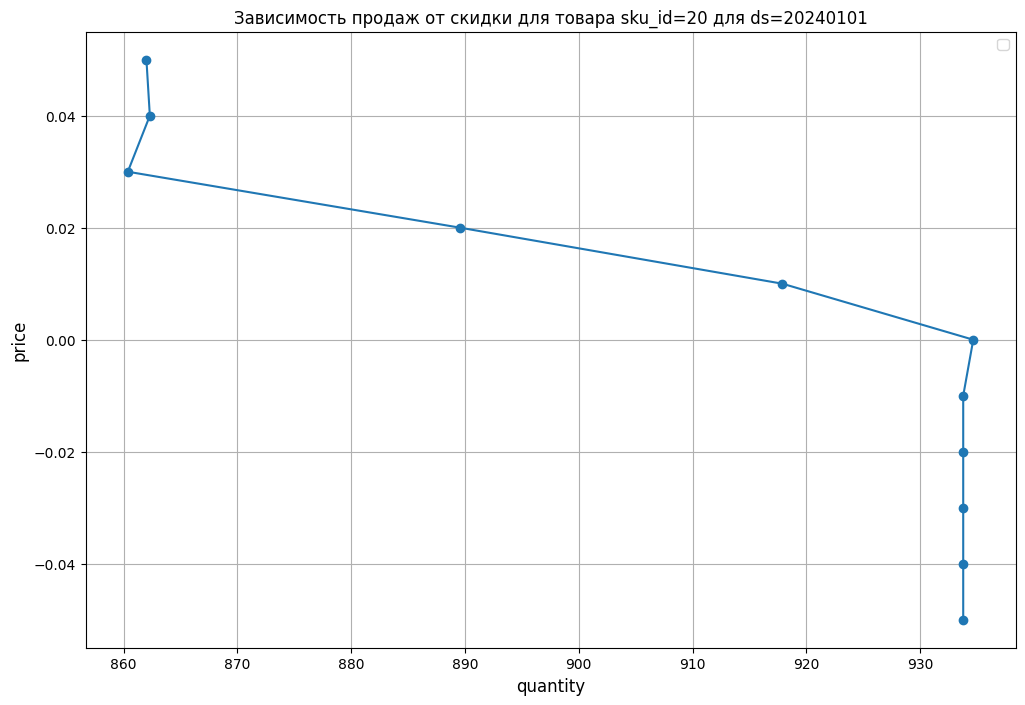

In [12]:
# Отрисуем кривую эластично для товра
SKU_ID = 20
plot_df = pred_df[(pred_df["sku_id"] == SKU_ID) & (pred_df["ds"] == START_DS)]

plt.figure(figsize=(12, 8))
plt.plot(plot_df["orders_num"], plot_df["discount"], marker="o")
plt.ylabel("price", fontsize=12)
plt.xlabel("quantity", fontsize=12)
plt.title(
    f"Зависимость продаж от скидки для товара sku_id={SKU_ID} для ds={START_DS}",
    fontsize=12,
)
plt.legend()
plt.grid(True)
plt.show()